# Classical pipeline

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import torch

BATCH_SIZE = 30
EPOCHS = 25
LEARNING_RATE = 3e-2
SEED = 0

### Input data

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

### Create diagrams

In [4]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

train_diagrams = reader.sentences2diagrams(train_data)
dev_diagrams = reader.sentences2diagrams(dev_data)
test_diagrams = reader.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Create circuits

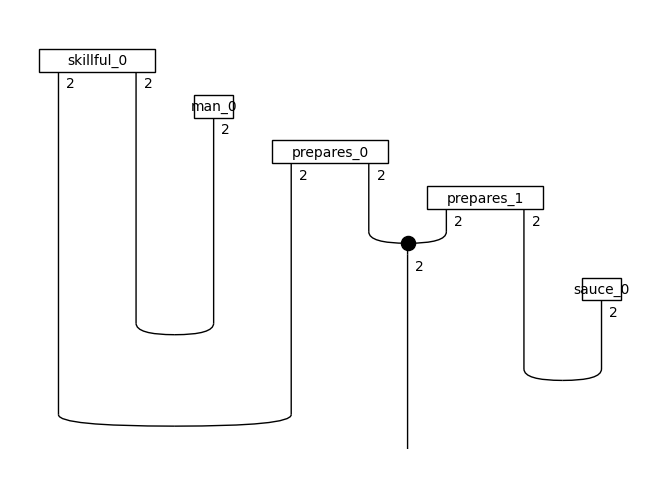

In [5]:
from discopy.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

### Parameterise

In [6]:
from lambeq import PytorchModel
all_circuits = train_circuits + dev_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

### Define Evaluation Metric

In [7]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

### Initialize Trainer

In [8]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,    # type: ignore
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions={"acc": accuracy},
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

In [9]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_circuits, dev_labels)

### Train

In [10]:
trainer.fit(train_dataset, dev_dataset, logging_step=5)

Epoch 1:   train/loss: 0.7287   valid/loss: 0.7285   train/acc: 0.5143   valid/acc: 0.5500
Epoch 5:   train/loss: 0.6473   valid/loss: 0.7113   train/acc: 0.6071   valid/acc: 0.5333
Epoch 10:  train/loss: 0.5289   valid/loss: 0.6112   train/acc: 0.6429   valid/acc: 0.6000
Epoch 15:  train/loss: 0.2938   valid/loss: 0.4805   train/acc: 0.8143   valid/acc: 0.7500
Epoch 20:  train/loss: 0.1413   valid/loss: 0.2196   train/acc: 0.9571   valid/acc: 0.9000
Epoch 25:  train/loss: 0.0299   valid/loss: 0.0654   train/acc: 0.9857   valid/acc: 0.9667

Training completed!


### Show results

Test accuracy: 0.9833333492279053


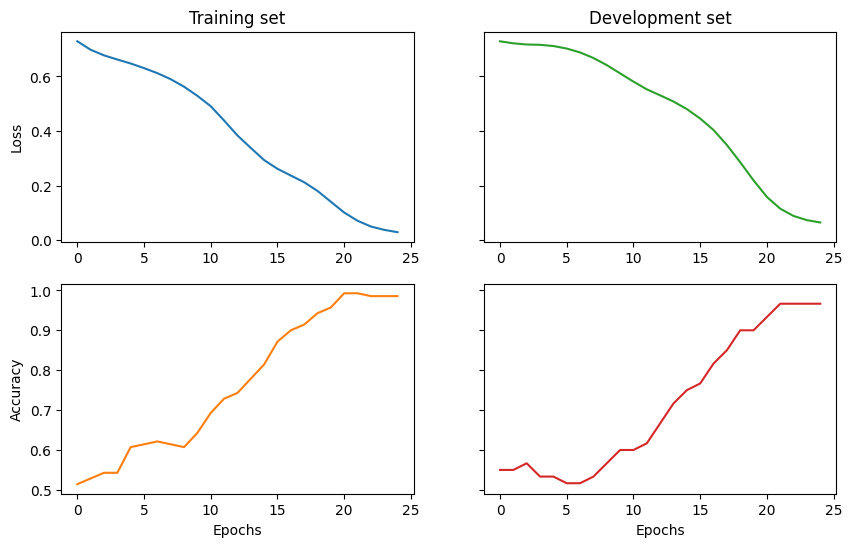

In [11]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model.forward(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())